In [6]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.api as sm
from sklearn.metrics import r2_score
from prophet import Prophet

In [7]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = (30,6)
matplotlib.rcParams['axes.titlesize']= 20

In [8]:
def mapperDictGenerator(df, label):
  d= dict()
  factorized= pd.factorize(df[label])
  for i, _ in enumerate(factorized[1]):
    d[i]= _
  return factorized[0], d

In [9]:
df=pd.read_csv('MCI_2014_to_2019.csv')
df.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,3,Assault,D14,79,University (79),-79.405228,43.656982,7001
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,...,227.0,Saturday,21,Assault,D42,118,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,...,228.0,Sunday,16,Break and Enter,D43,137,Woburn (137),-79.225029,43.765942,7003
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,...,330.0,Thursday,13,Break and Enter,D43,133,Centennial Scarborough (133),-79.140823,43.778648,7004
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,19,Assault,D55,61,Taylor-Massey (61),-79.288361,43.691235,7005


In [10]:
df.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Hood_ID,Long,Lat,ObjectId
count,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206376.000000,206376.000000,206376.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000
mean,-79.394940,43.707379,103218.000000,1696.667755,145.973953,2016.619323,15.746855,187.139933,12.838617,2016.579171,15.511024,186.506653,12.549868,72.230286,-79.394940,43.707379,103218.000000
std,0.104386,0.052718,59592.795747,323.481988,51.739660,1.717764,8.770511,103.601412,6.583508,1.764401,8.904154,103.884073,7.220263,40.758981,0.104386,0.052718,59592.795747
min,-79.639267,43.587093,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,1.000000,-79.639267,43.587093,1.000000
25%,-79.471481,43.661152,51609.500000,1430.000000,100.000000,2015.000000,8.000000,100.000000,8.000000,2015.000000,8.000000,99.000000,7.000000,36.000000,-79.471481,43.661152,51609.500000
50%,-79.393333,43.701328,103218.000000,1450.000000,100.000000,2017.000000,16.000000,189.000000,14.000000,2017.000000,16.000000,188.000000,14.000000,76.000000,-79.393333,43.701328,103218.000000
75%,-79.319374,43.752068,154826.500000,2120.000000,200.000000,2018.000000,23.000000,277.000000,18.000000,2018.000000,23.000000,276.000000,19.000000,108.000000,-79.319374,43.752068,154826.500000
max,-79.123100,43.850788,206435.000000,2135.000000,230.000000,2019.000000,31.000000,366.000000,23.000000,2019.000000,31.000000,366.000000,23.000000,140.000000,-79.123100,43.850788,206435.000000


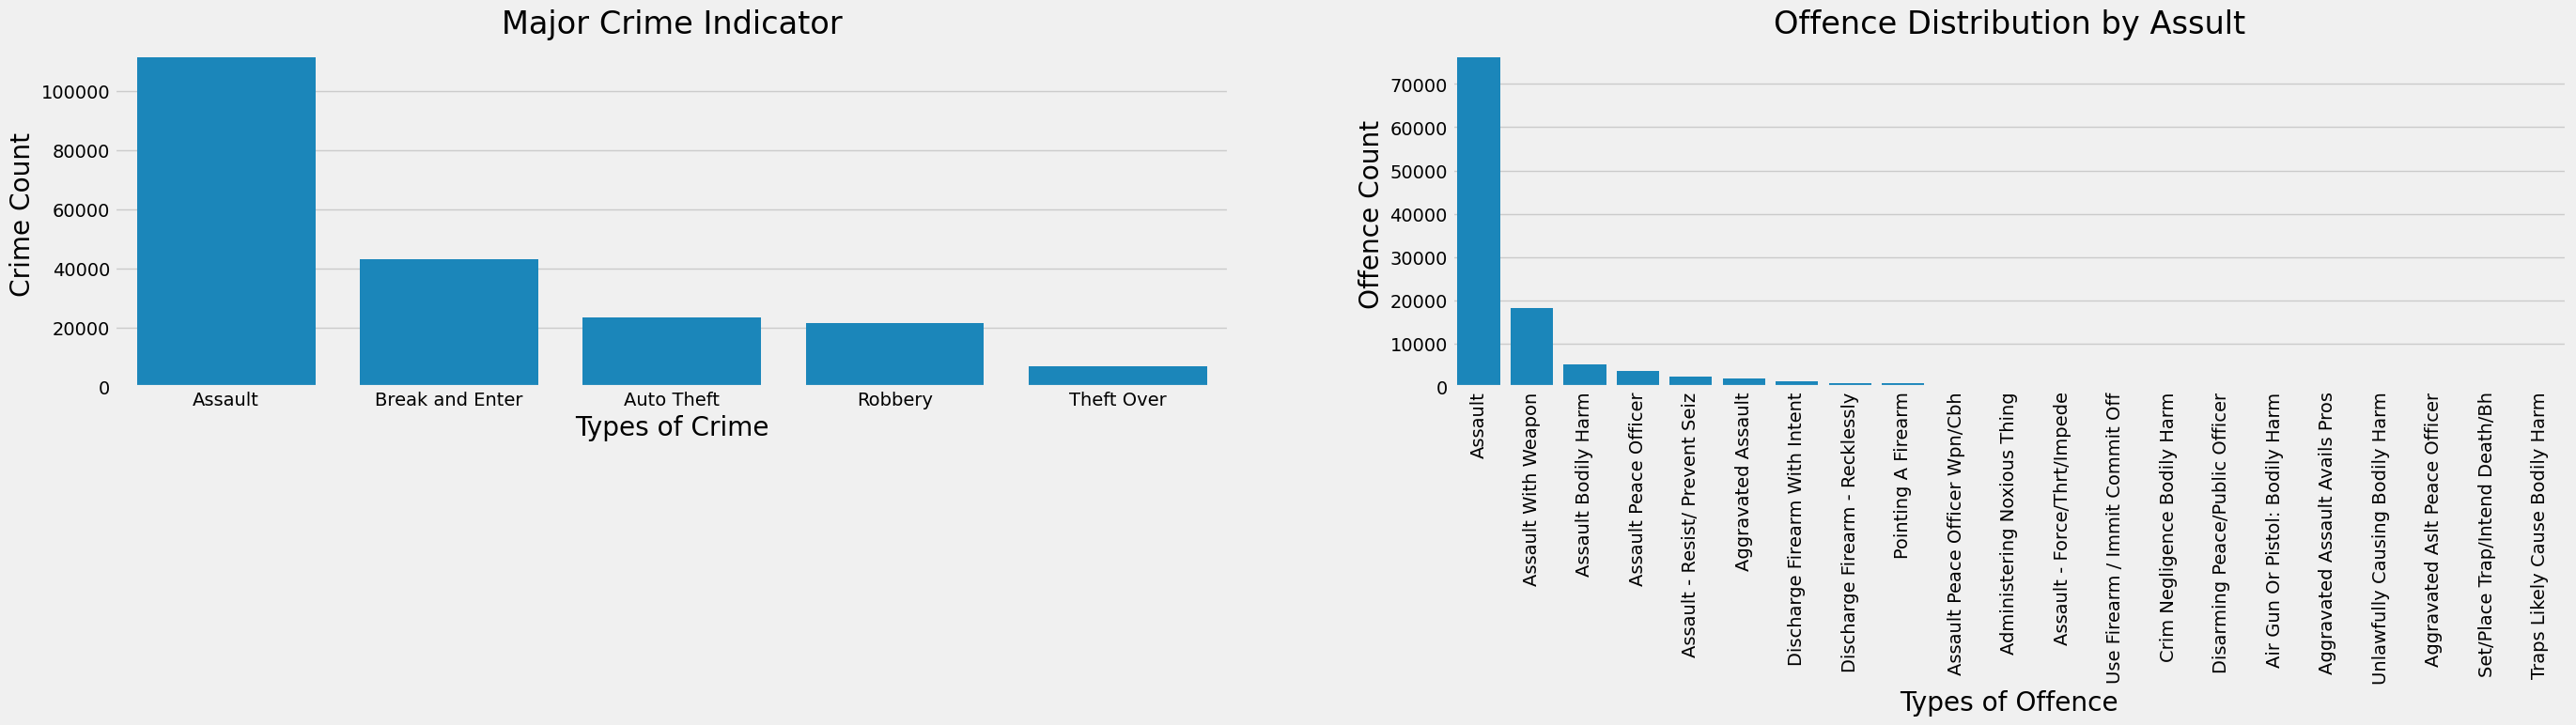

In [11]:
plt.figure(figsize=(30,10))
MCI= df.groupby('MCI',as_index=False).size()
assaultTypes= df[df.MCI=='Assault'].groupby('offence', as_index=False).size()
autoTheftTypes= df[df.MCI=='Auto Theft'].groupby('offence', as_index=False).size()

plt.subplot(221)
sns.barplot(x='MCI', y='size', data=MCI.sort_values(by='size', ascending=False))
plt.title('Major Crime Indicator', fontsize='xx-large')
plt.xlabel('Types of Crime', fontsize='x-large')
plt.ylabel('Crime Count', fontsize='x-large')

plt.subplot(222)
sns.barplot(x='offence', y='size', data=assaultTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Assult', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)



plt.show()

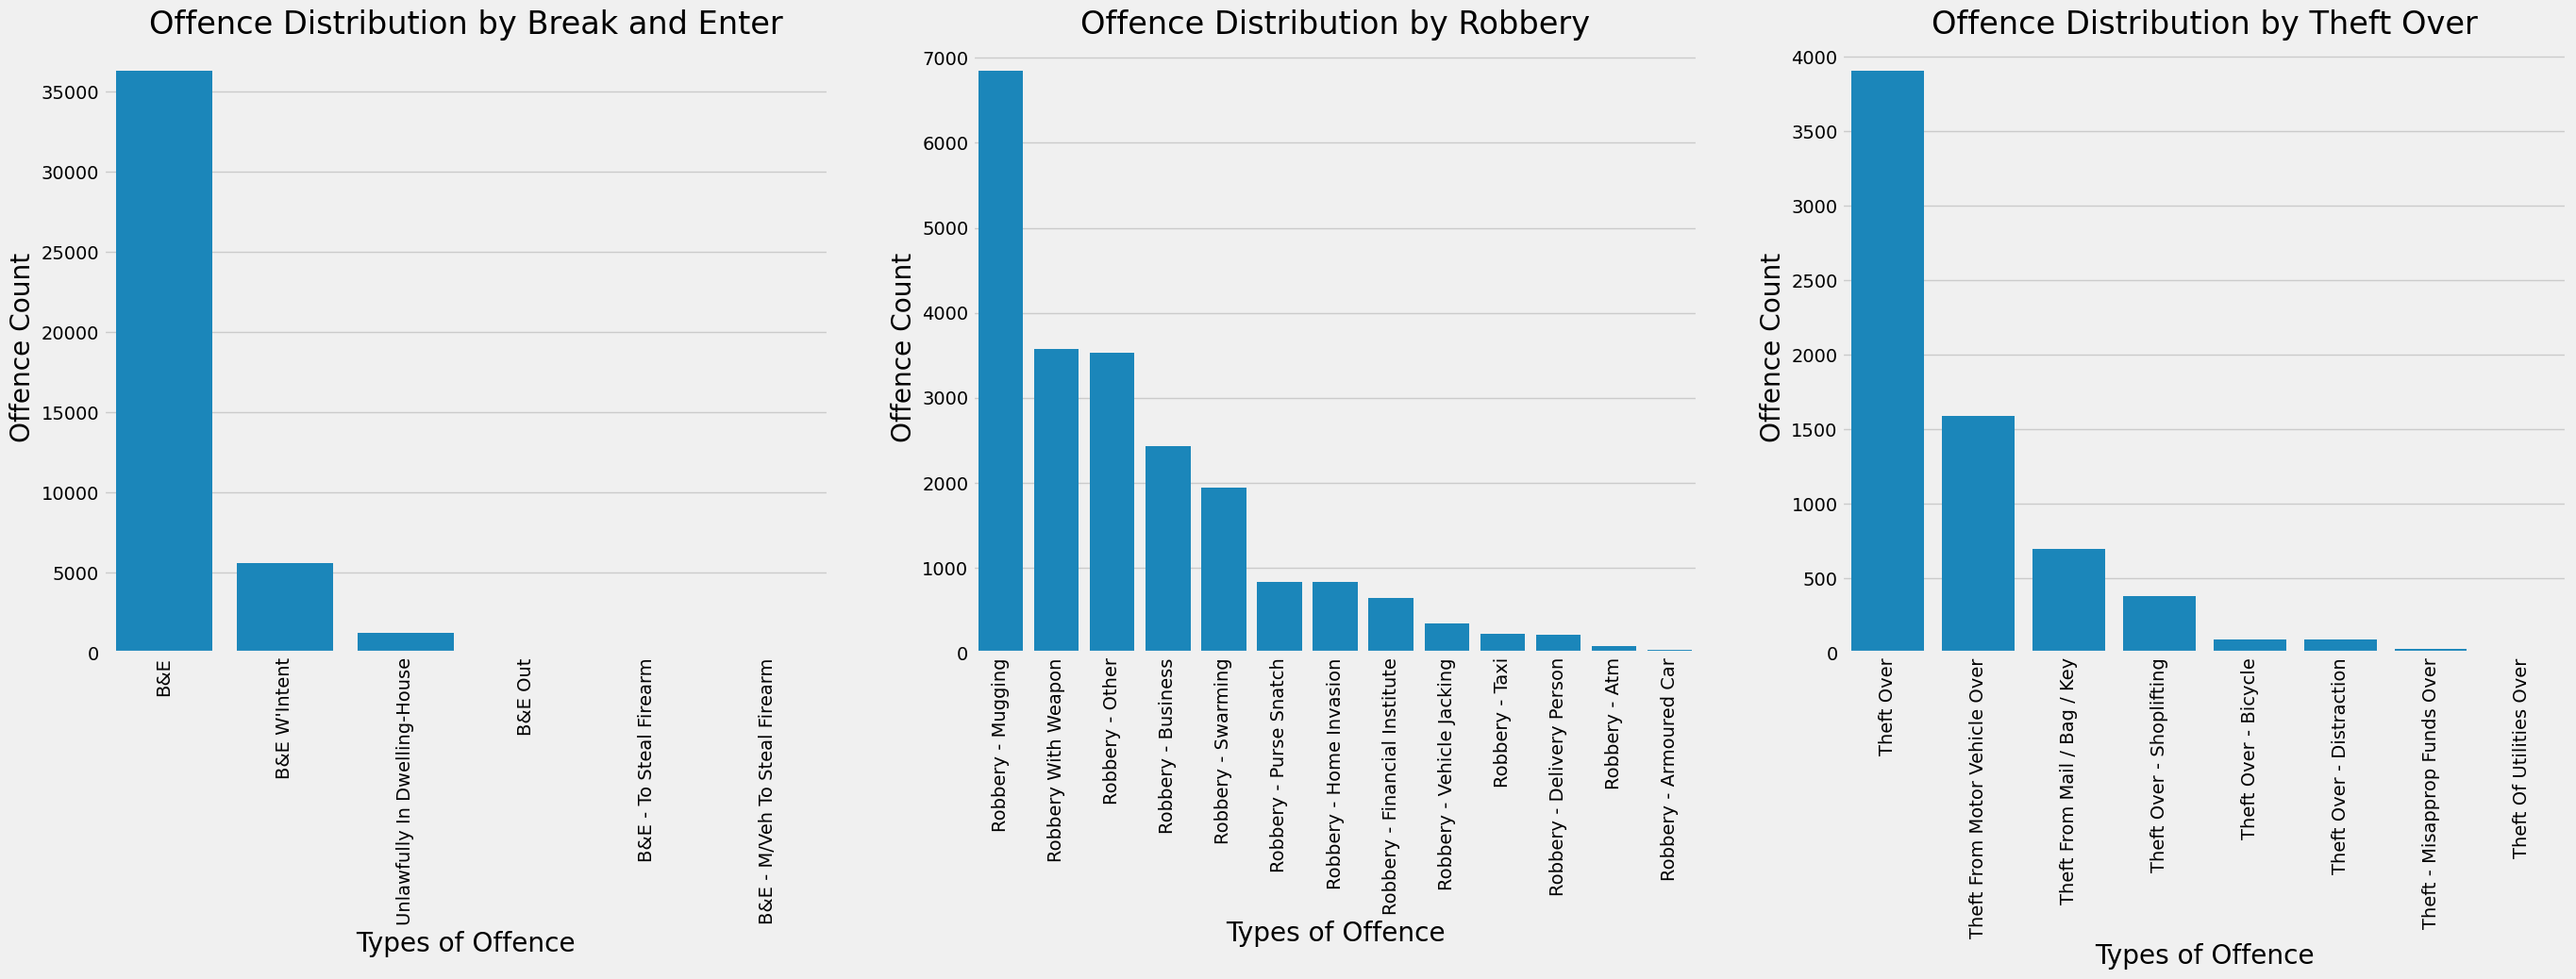

In [12]:
plt.figure(figsize=(30,8))

breakEnterTypes= df[df.MCI=='Break and Enter'].groupby('offence', as_index=False).size()
robberyTypes= df[df.MCI=='Robbery'].groupby('offence', as_index=False).size()
theftOverTypes= df[df.MCI=='Theft Over'].groupby('offence', as_index=False).size()

plt.subplot(131)
sns.barplot(x='offence', y='size', data=breakEnterTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Break and Enter', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(132)
sns.barplot(x='offence', y='size', data=robberyTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Robbery', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(133)
sns.barplot(x='offence', y='size', data=theftOverTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Theft Over', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.show()

In [14]:
# Convert 'reporteddate' to datetime
df.reporteddate = pd.to_datetime(df.reporteddate)

# Extract date as datetime (not just date)
df['reportOnlyDate'] = pd.to_datetime(df.reporteddate.dt.date)

# Convert 'occurrencedate' to datetime
df.occurrencedate = pd.to_datetime(df.occurrencedate)

# Extract date as datetime (not just date)
df['occurrenceOnlyDate'] = pd.to_datetime(df.occurrencedate.dt.date)

# Calculate the delay in reporting
df['delayInReporting'] = (df['reportOnlyDate'] - df['occurrenceOnlyDate']).dt.days

In [15]:
df['count']= 1
mci_monthwise = df.groupby(['occurrenceday','MCI'],as_index=False).agg({'count':'sum'})

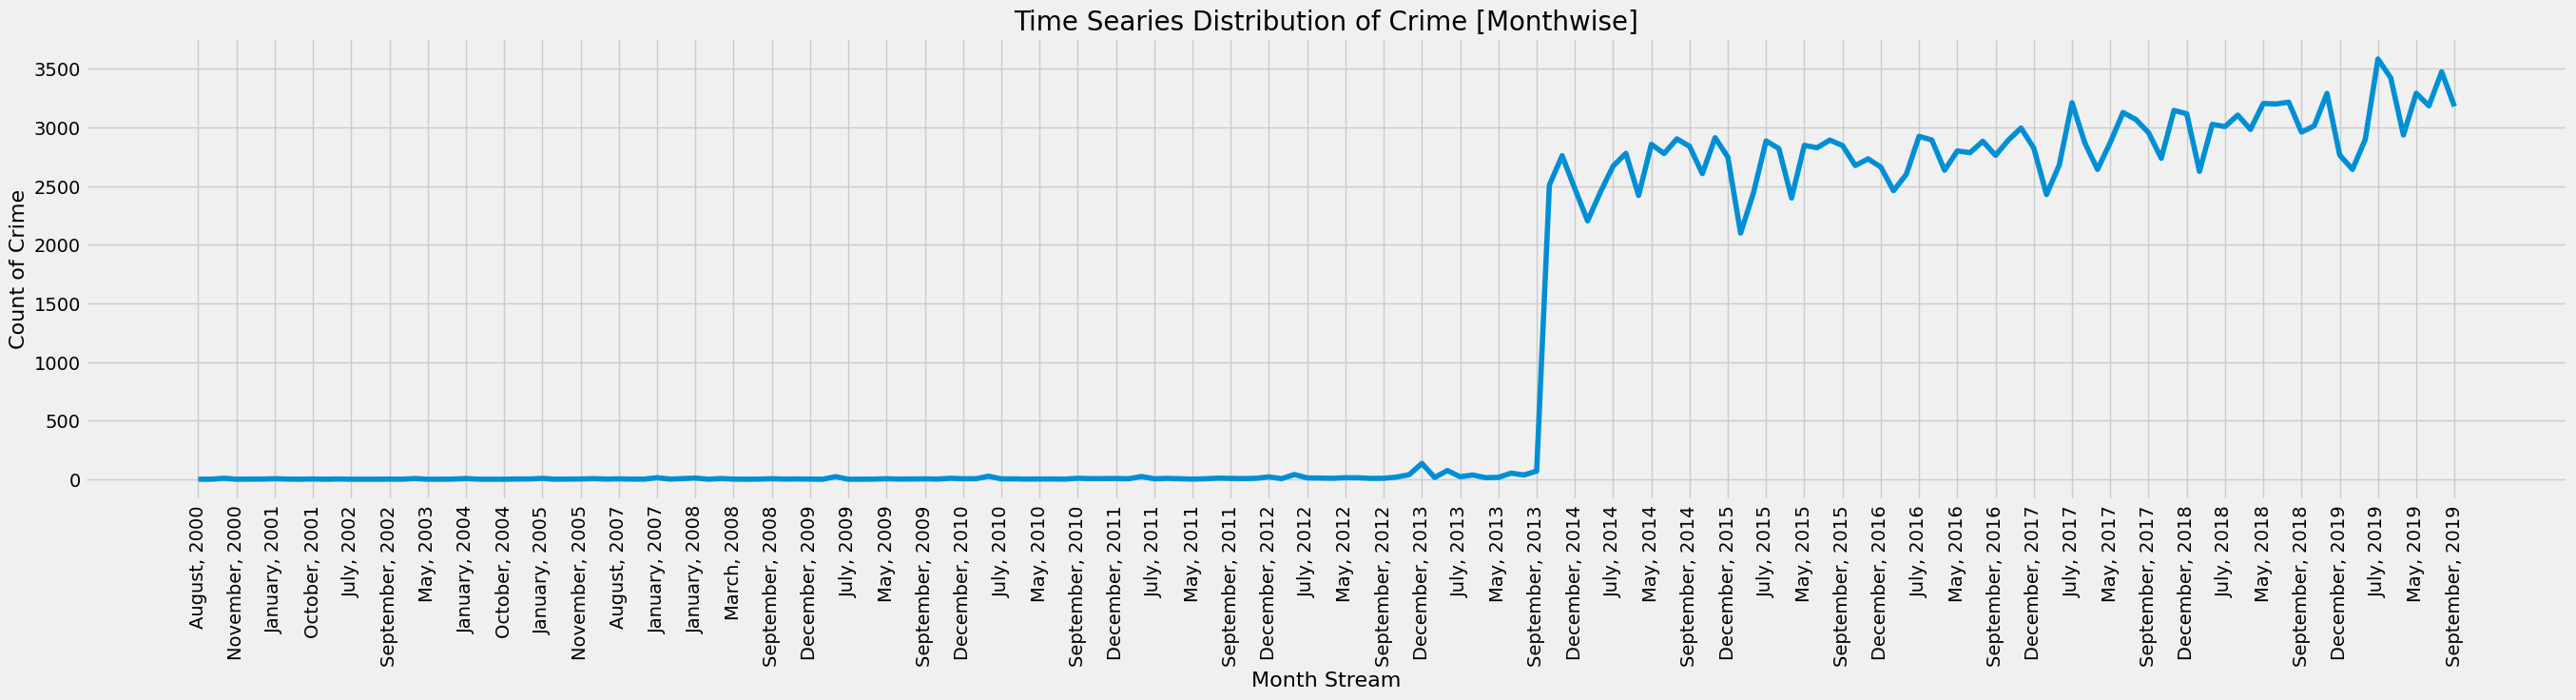

In [16]:
mci_distribution = df.groupby(['occurrenceyear','occurrencemonth'],as_index=False).agg({'count':'sum'})
mci_distribution['occurrenceyear']= mci_distribution['occurrenceyear'].astype('int').astype('str')
mci_distribution['monthYear']= mci_distribution['occurrencemonth'] +', '+ mci_distribution['occurrenceyear']

plt.grid('on')
plt.plot(mci_distribution['monthYear'], mci_distribution['count'])
plt.xlabel('Month Stream')
plt.ylabel('Count of Crime')
plt.title('Time Searies Distribution of Crime [Monthwise]')
plt.xticks(np.arange(0, mci_distribution['monthYear'].shape[0], 3), rotation=90)
plt.show()

In [18]:
# Filter rows where occurrenceOnlyDate is after '2014-12-31'
trimmedOccuranceDateVsMciCount = occuranceDateVsMciCount[occuranceDateVsMciCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31')]

In [20]:
# Summing counts by occurrence date
occuranceDateCount = df.groupby('occurrenceOnlyDate')['count'].sum().reset_index()

# Filtering rows with occurrence dates after '2014-12-31'
trimmedOccuranceDateCount = occuranceDateCount[occuranceDateCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31')]

# Ensuring the occurrenceOnlyDate column is in datetime format and setting it as the index
trimmedOccuranceDateCount['occurrenceOnlyDate'] = pd.to_datetime(trimmedOccuranceDateCount['occurrenceOnlyDate'])
trimmedOccuranceDateCount.set_index('occurrenceOnlyDate', inplace=True)

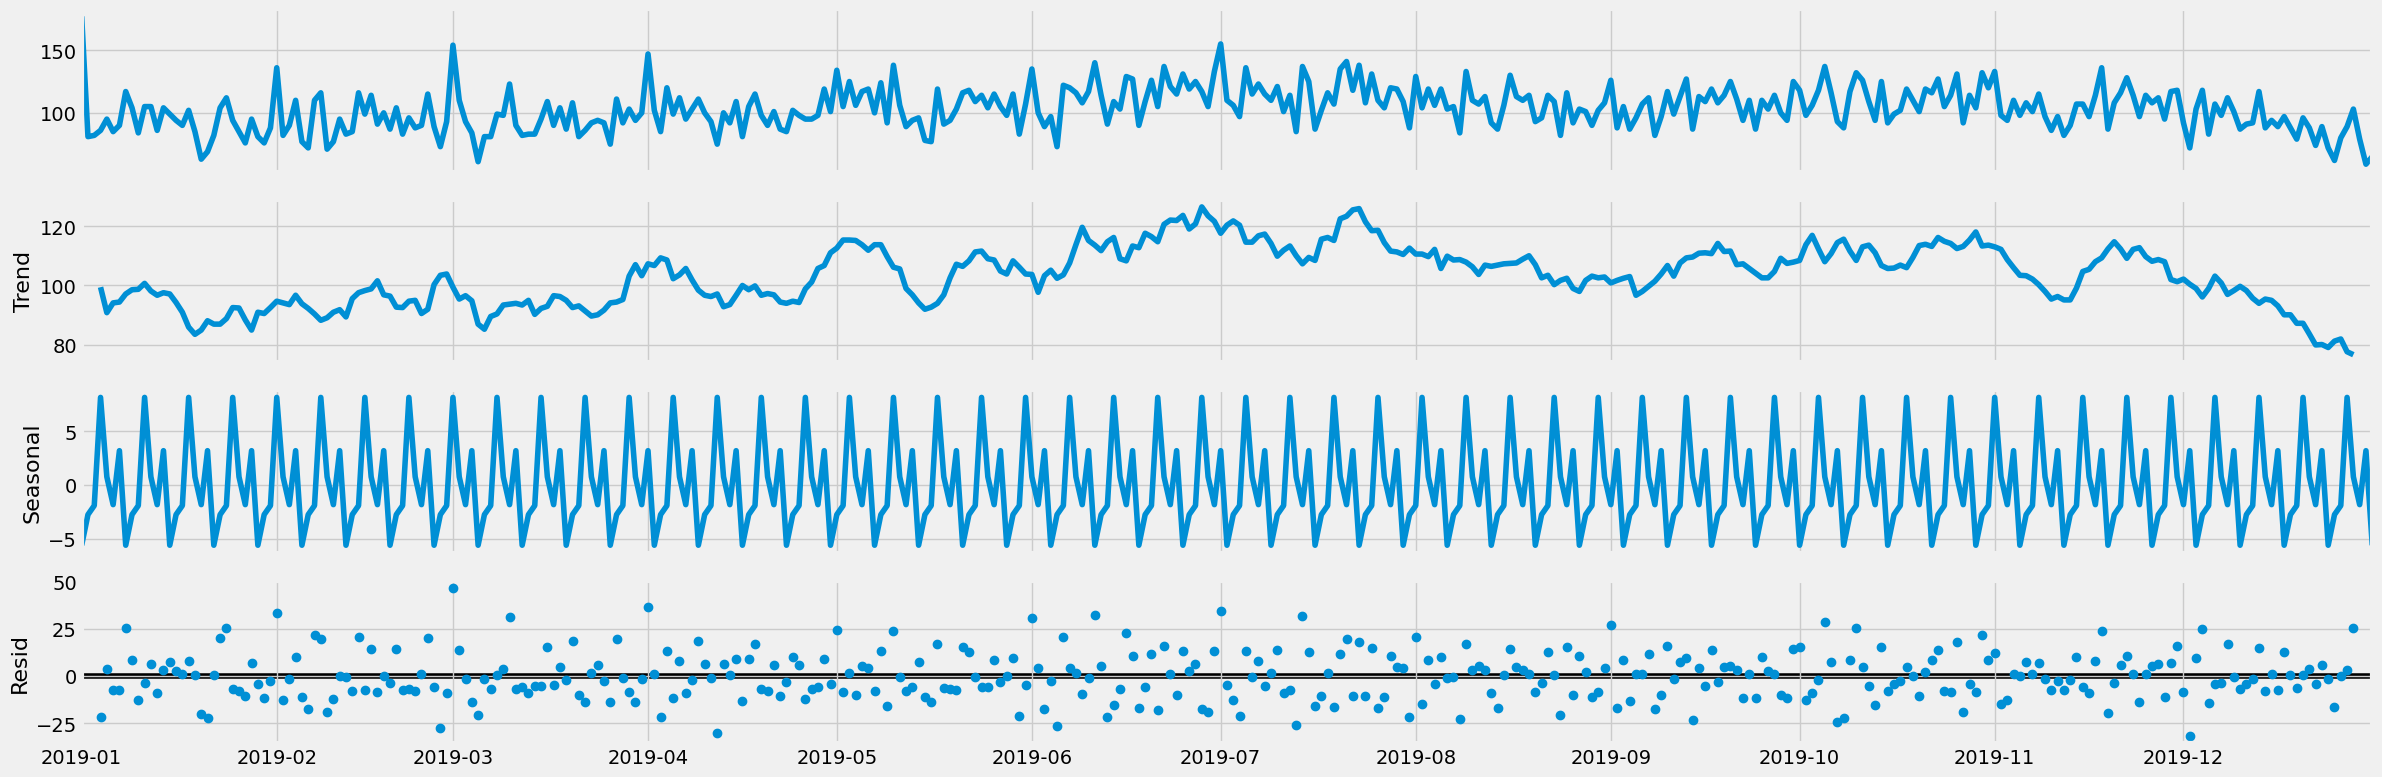

In [21]:
decomposition= sm.tsa.seasonal_decompose(trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')], model='additive')

plt.rcParams['figure.figsize'] = 24, 8
decomposition.plot()

plt.show()

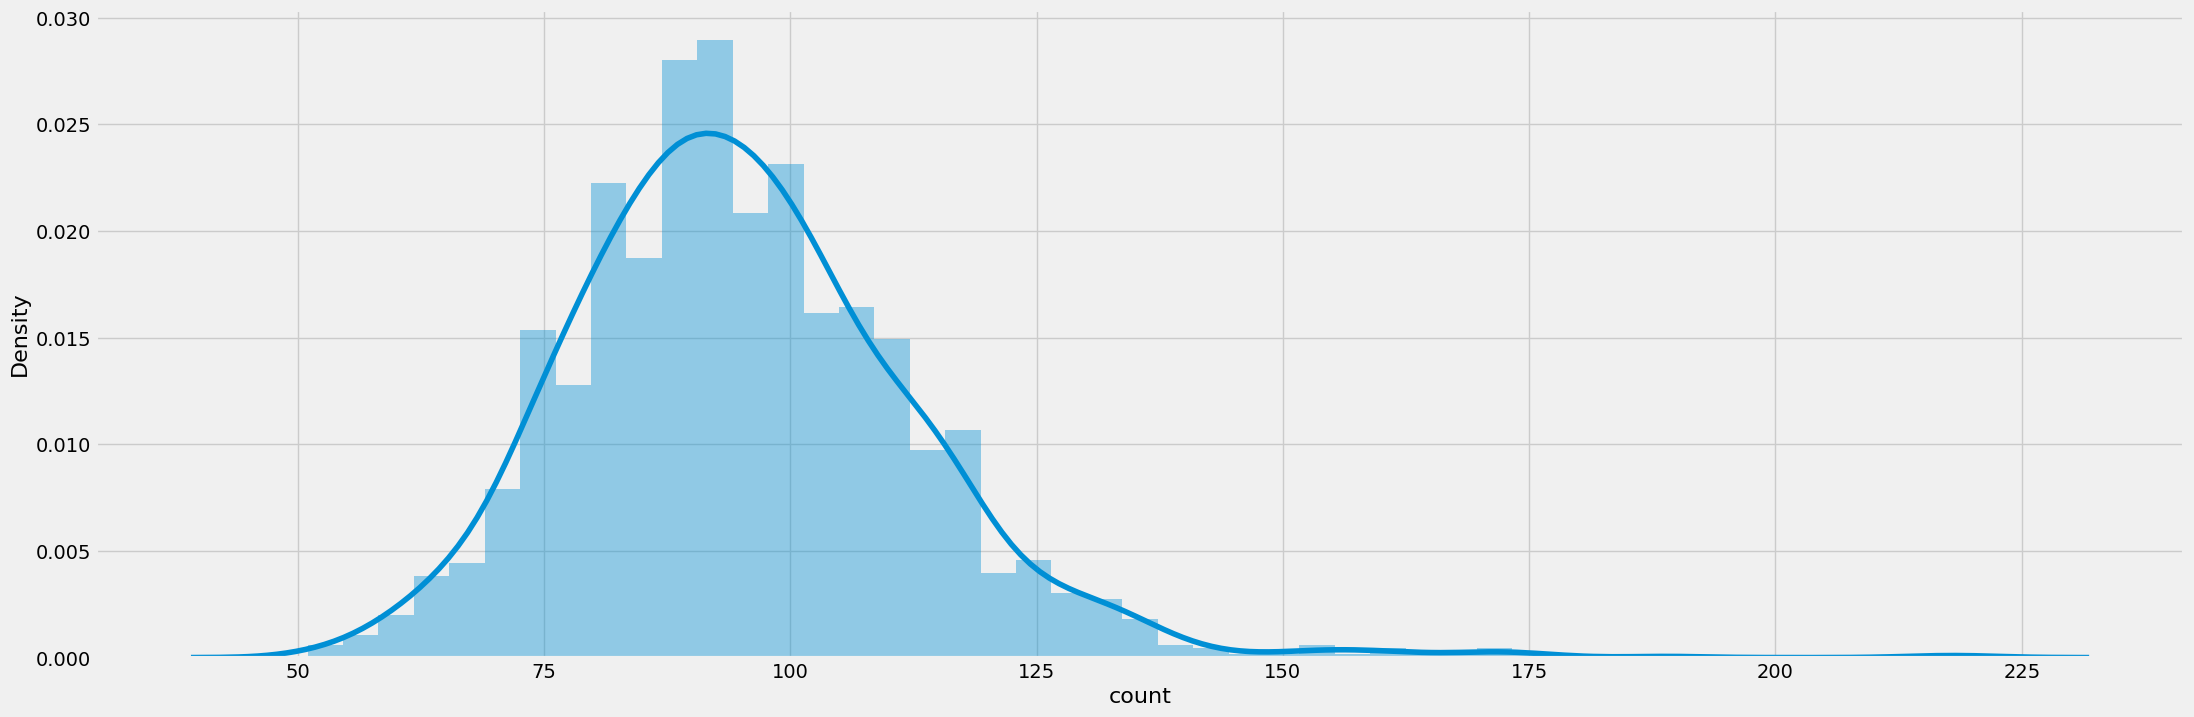

In [22]:
sns.distplot(trimmedOccuranceDateCount['count'])
plt.show()

In [23]:
trainData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index < pd.to_datetime('2018-12-31')]
testData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')]

y= trimmedOccuranceDateCount['count'].resample('MS').mean()

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

resultDict= dict()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod= sm.tsa.statespace.SARIMAX(trainData, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results= mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            resultDict['ARIMA{}x{}12'.format(param, param_seasonal)]= results.aic
        except:
            continue

minIndexARIMA= list(resultDict.keys())[(list(resultDict.values()).index(min(resultDict.values())))]
print('MIN INDEX: {}'.format(minIndexARIMA))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:17416.567419692547
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15834.289307207702
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13080.942401398419
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:12173.56633782788
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13114.613248496138
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:12239.61784405569
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:12664.253674635018
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12173.58589097668
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:15918.053941883983
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14988.462581171822
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13056.04538203
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:12125.886753981637
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:13093.041692417602
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12192.60635725128
ARIMA(0, 0, 1)x(1, 1, 0, 12

In [25]:
crimeforecast=results.forecast(steps=365)[0]
testData

,count
occurrenceOnlyDate,
2019-01-01,177
2019-01-02,81
2019-01-03,82
2019-01-04,86
2019-01-05,95
...,...
2019-12-27,89
2019-12-28,103
2019-12-29,79


In [26]:
SARIMAXmodel= sm.tsa.statespace.SARIMAX(trainData, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
SARIMAXresults= SARIMAXmodel.fit()
print(SARIMAXresults.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0994      0.025      3.964      0.000       0.050       0.149
ma.L1         -1.0365      0.008   -136.455      0.000      -1.051      -1.022
ma.S.L12      -1.0000     33.359     -0.030      0.976     -66.383      64.383
sigma2       234.1511   7811.361      0.030      0.976   -1.51e+04    1.55e+04


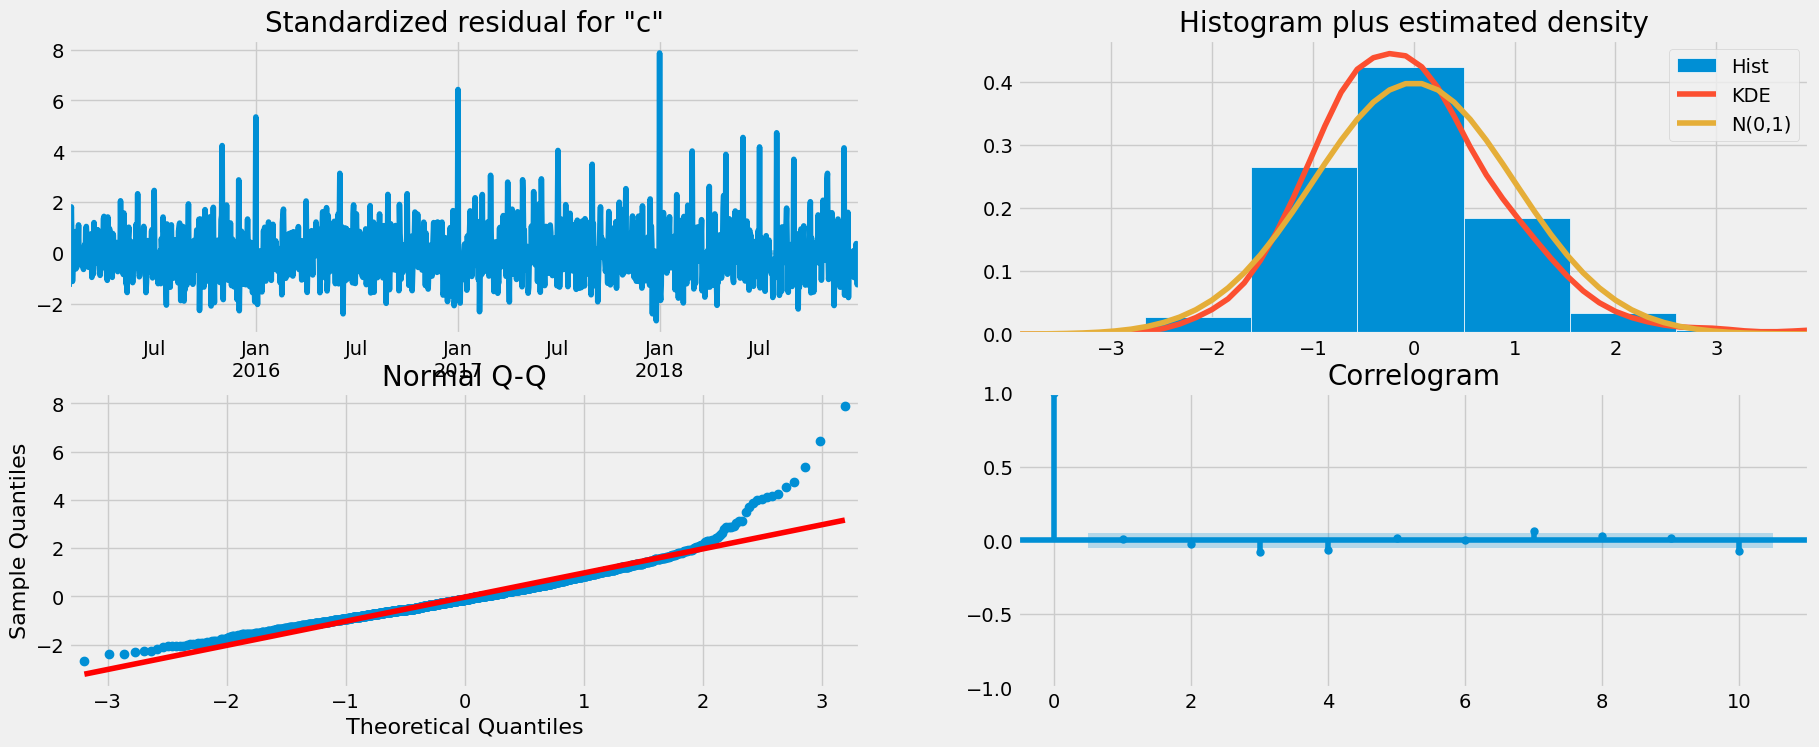

In [27]:
SARIMAXresults.plot_diagnostics(figsize=(20, 8))
plt.show()

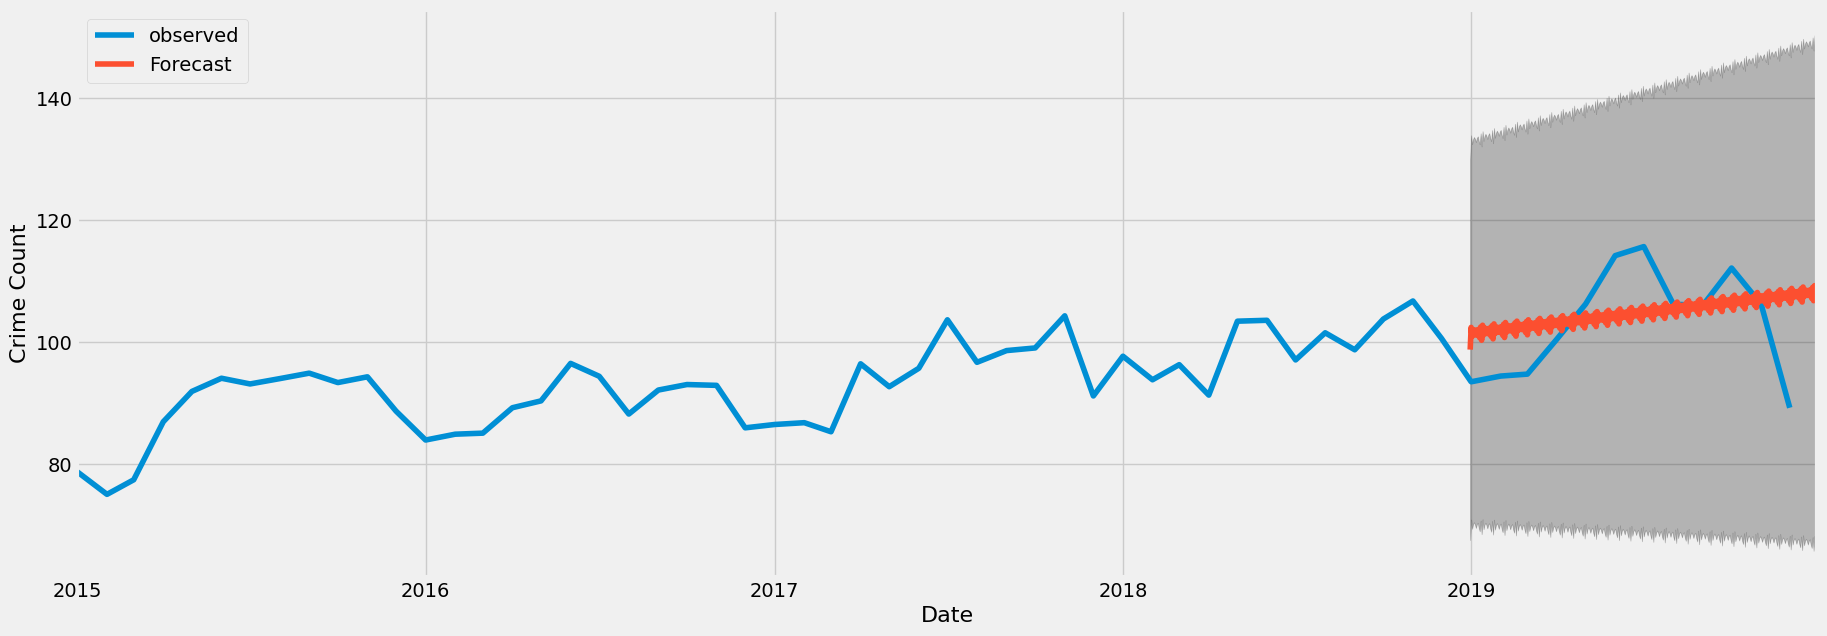

In [28]:
pred_uc= SARIMAXresults.get_forecast(steps=365)
pred_ci= pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(20, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
plt.legend()
plt.show()

In [29]:
testData['predValues']= pred_uc.predicted_mean.astype('int')

testData['lowerCount']= pred_ci[pred_ci.index >= testData.index.min()]['lower count']
testData['upperCount']= pred_ci[pred_ci.index >= testData.index.min()]['upper count']

mse= round(((testData['count'] - testData['predValues'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((testData['upperCount'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((testData['lowerCount'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(testData.head())

Mean Square Error: 285.83
Root Mean Square Error: 16.91
Mean Square Error with Upper Envelop: 1707.73
Root Mean Square Error with Upper Envelop: 41.32
Mean Square Error with Lower Envelop: 1503.55
Root Mean Square Error with Lower Envelop: 38.78

                    count  predValues  lowerCount  upperCount
occurrenceOnlyDate                                           
2019-01-01            177       102.0   70.838782  133.831626
2019-01-02             81       100.0   69.308980  132.374863
2019-01-03             82       101.0   70.064414  133.179837
2019-01-04             86       101.0   70.381295  133.544140
2019-01-05             95       101.0   70.029398  133.238224


In [30]:
trimmedOccuranceDateCountProphetFit= trainData.reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
prophet_model= Prophet(daily_seasonality=True)
prophet_model.fit(trimmedOccuranceDateCountProphetFit)

19:22:26 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
prophetForecast= prophet_model.make_future_dataframe(periods=365)
prophetForecast= prophet_model.predict(prophetForecast)

<Figure size 1800x600 with 0 Axes>

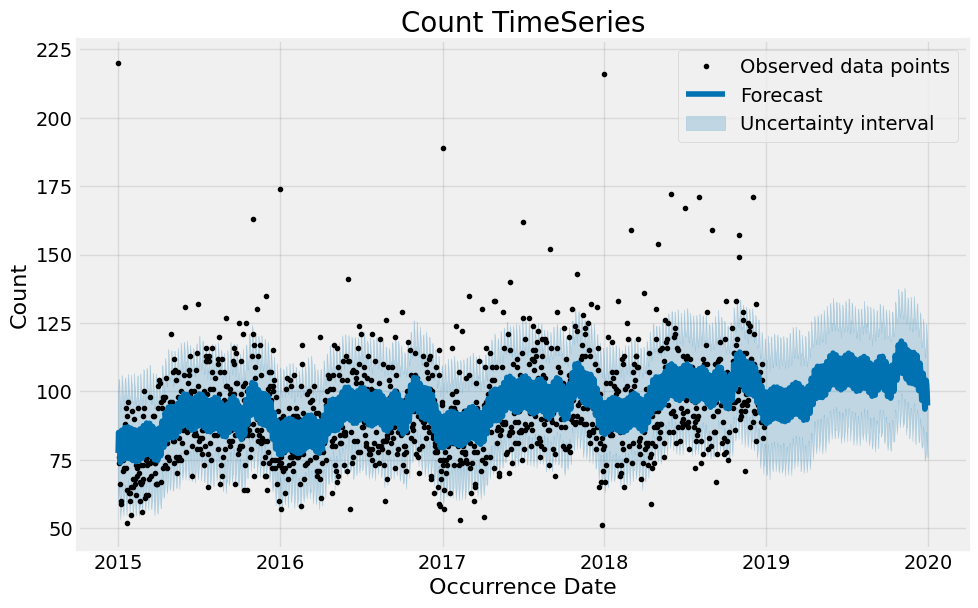

In [32]:
plt.figure(figsize=(18, 6))
prophet_model.plot(prophetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.legend()
plt.title('Count TimeSeries');

In [33]:
prophetForcast_yhat= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
prophetForcast_trend= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['trend', 'trend_lower', 'trend_upper']]
for _ in tqdm(prophetForcast_yhat.columns):
  prophetForcast_yhat[_]= prophetForcast_yhat[_].astype('int')
for _ in tqdm(prophetForcast_trend.columns):
  prophetForcast_trend[_]= prophetForcast_trend[_].astype('int')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1503.33it/s]


In [34]:
mse= round(((testData['count'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Complete yHat Data Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(prophetForcast_yhat.head())

Prophet Complete yHat Data Error Analysis

Mean Square Error: 249.04
Root Mean Square Error: 15.78
Mean Square Error with Upper Envelop: 602.93
Root Mean Square Error with Upper Envelop: 24.55
Mean Square Error with Lower Envelop: 668.93
Root Mean Square Error with Lower Envelop: 25.86

            yhat  yhat_lower  yhat_upper
ds                                      
2019-01-01    88          69         108
2019-01-02    90          70         111
2019-01-03    92          72         111
2019-01-04    99          80         120
2019-01-05    98          79         117


In [35]:
mse= round(((testData['predValues'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['upperCount'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['lowerCount'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))

Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis

Mean Square Error: 35.77
Root Mean Square Error: 5.98
Mean Square Error with Upper Envelop: 383.34
Root Mean Square Error with Upper Envelop: 19.58
Mean Square Error with Lower Envelop: 253.93
Root Mean Square Error with Lower Envelop: 15.94


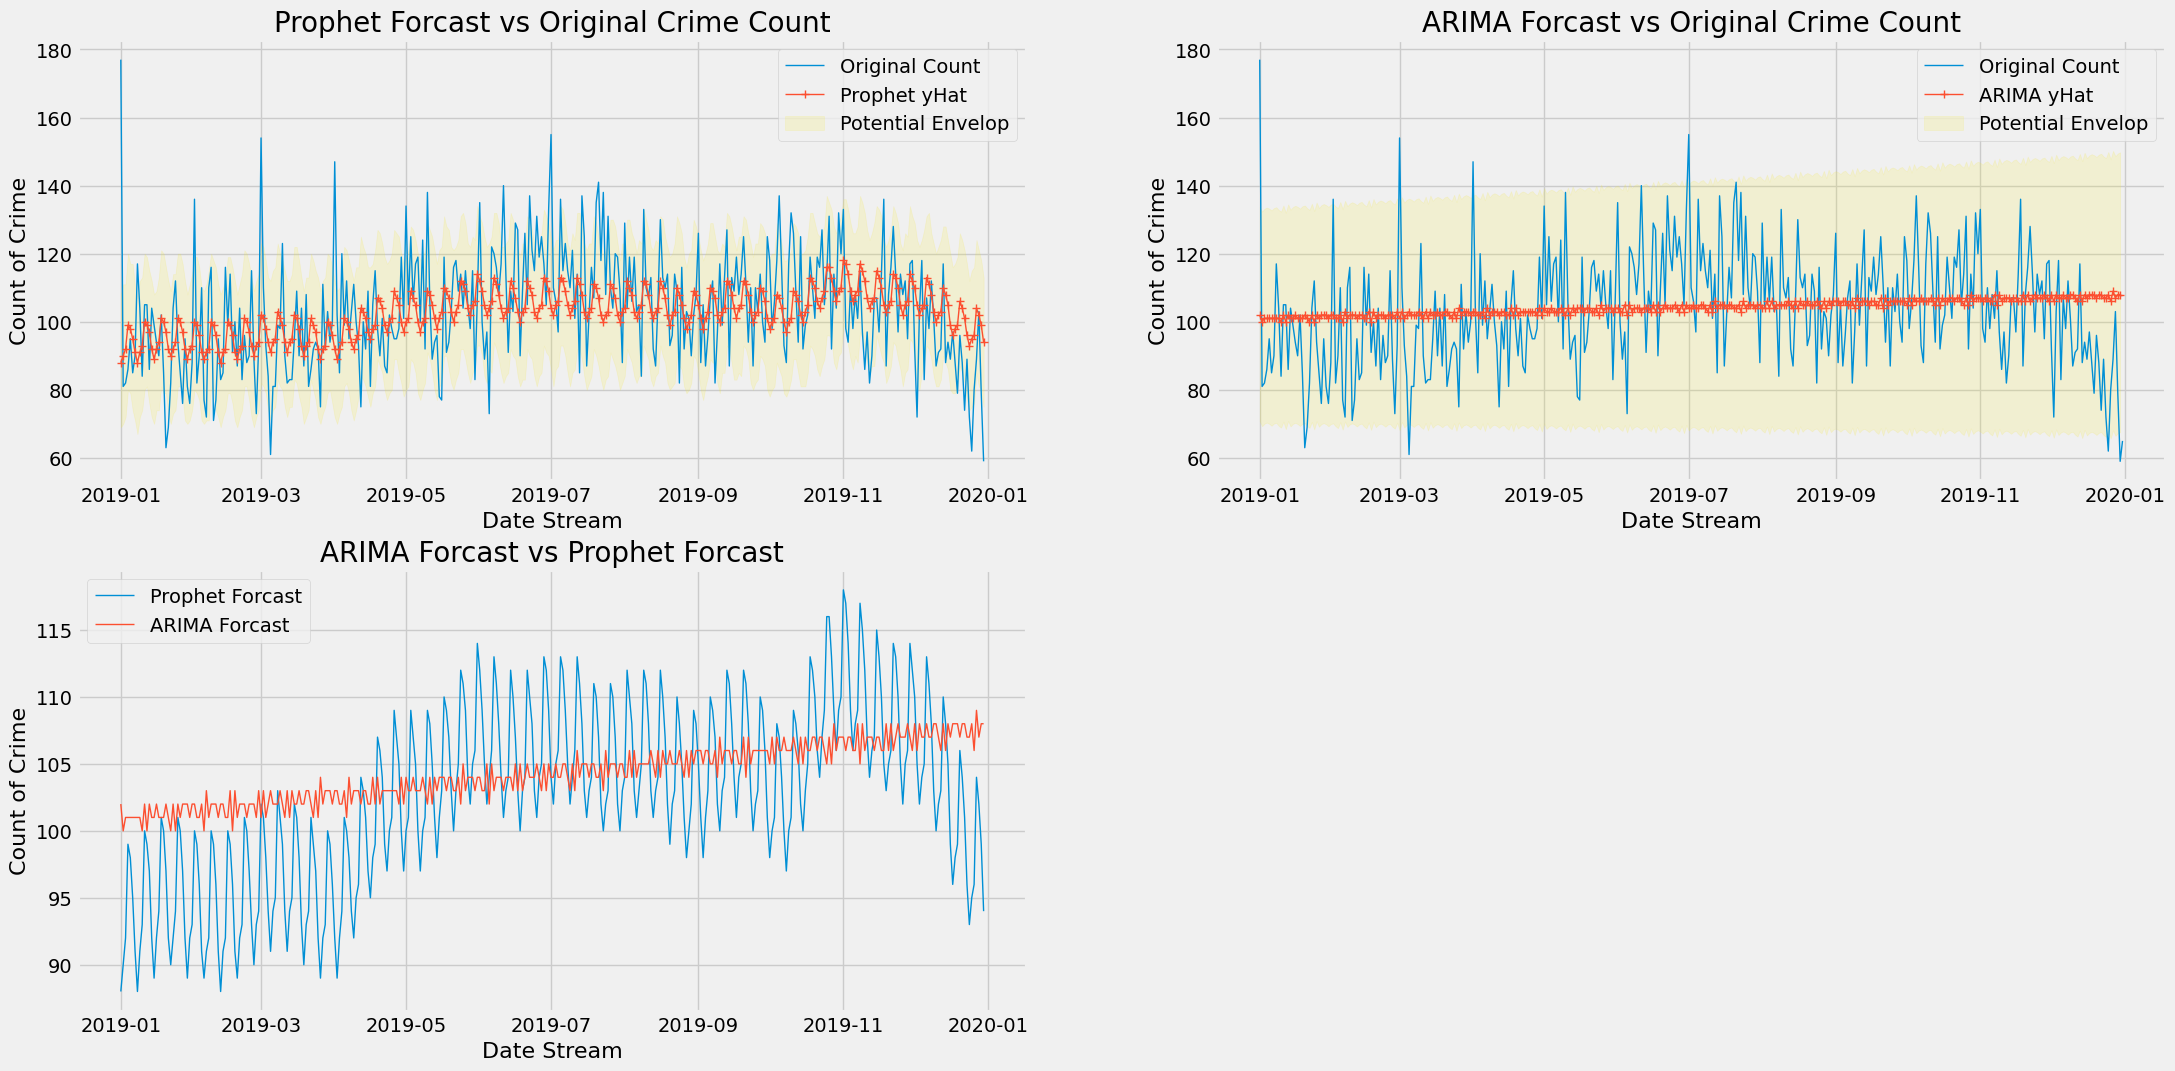

In [36]:
plt.rcParams['figure.figsize']= 24, 12

plt.subplot(221)
plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count')
plt.plot(prophetForcast_yhat.index, testData['count'].iloc[:-1], lw=1)
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1, marker='+')
plt.fill_between(prophetForcast_yhat.index, prophetForcast_yhat['yhat_upper'], prophetForcast_yhat['yhat_lower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])


plt.subplot(222)
plt.grid('on')
plt.title('ARIMA Forcast vs Original Crime Count')
plt.plot(testData.index, testData['count'], lw=1)
plt.plot(testData.index, testData['predValues'], lw=1, marker='+')
plt.fill_between(testData.index, testData['upperCount'], testData['lowerCount'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'ARIMA yHat', 'Potential Envelop'])

plt.subplot(223)
plt.grid('on')
plt.title('ARIMA Forcast vs Prophet Forcast')
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1)
plt.plot(testData.index[:-1], testData['predValues'][:-1], lw=1)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Prophet Forcast', 'ARIMA Forcast'])

plt.show()

In [37]:
print('Different Major Crime Indicators', end='\n\n')
for i, _ in enumerate(np.unique(df.MCI)):
  print('{}. {}'.format(i, _))

  mciDifferedResult= pd.DataFrame()

Different Major Crime Indicators

0. Assault
1. Auto Theft
2. Break and Enter
3. Robbery
4. Theft Over


19:24:54 - cmdstanpy - INFO - Chain [1] start processing
19:24:55 - cmdstanpy - INFO - Chain [1] done processing


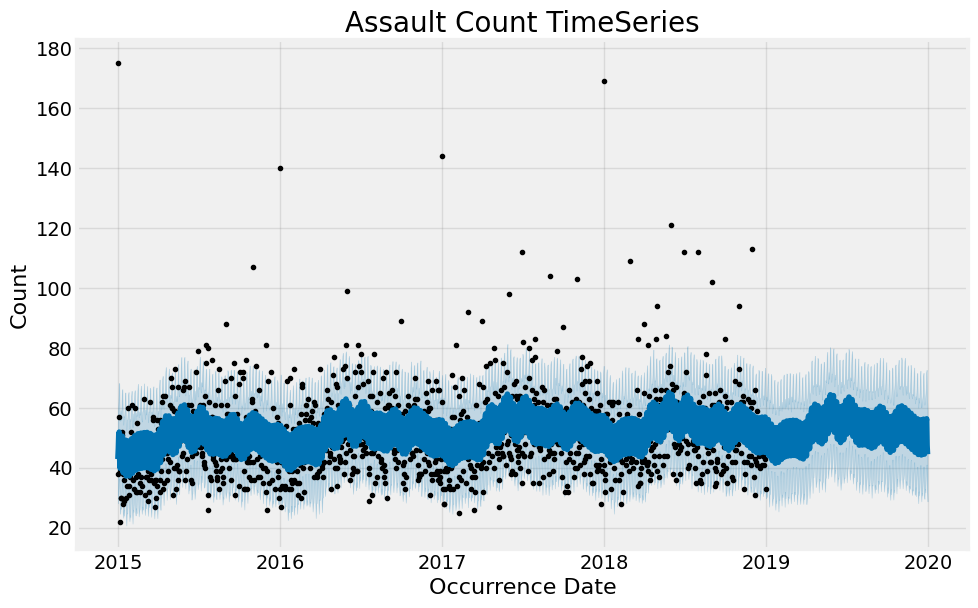

In [39]:
# Filter and rename columns for Prophet modeling
assaultTimewiseData = (
    df[df.MCI == 'Assault']
    .groupby('occurrenceOnlyDate')['count']
    .sum()
    .reset_index()
)

# Filter dates after '2014-12-31' and rename columns for Prophet
assaultTimewiseData = (
    assaultTimewiseData[assaultTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31')]
    .reset_index(drop=True)
    .rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
)

# Fit the Prophet model on data before '2019-01-01'
assaultProphetModel = Prophet(daily_seasonality=True).fit(
    assaultTimewiseData[assaultTimewiseData.ds < pd.to_datetime('2019-01-01')]
)

# Create future dates for forecasting
assaultProphetForecast = assaultProphetModel.make_future_dataframe(periods=365)
assaultProphetForecast = assaultProphetModel.predict(assaultProphetForecast)

# Plot the forecast
assaultProphetModel.plot(assaultProphetForecast, xlabel='Occurrence Date', ylabel='Count')
plt.title('Assault Count TimeSeries')
plt.show()


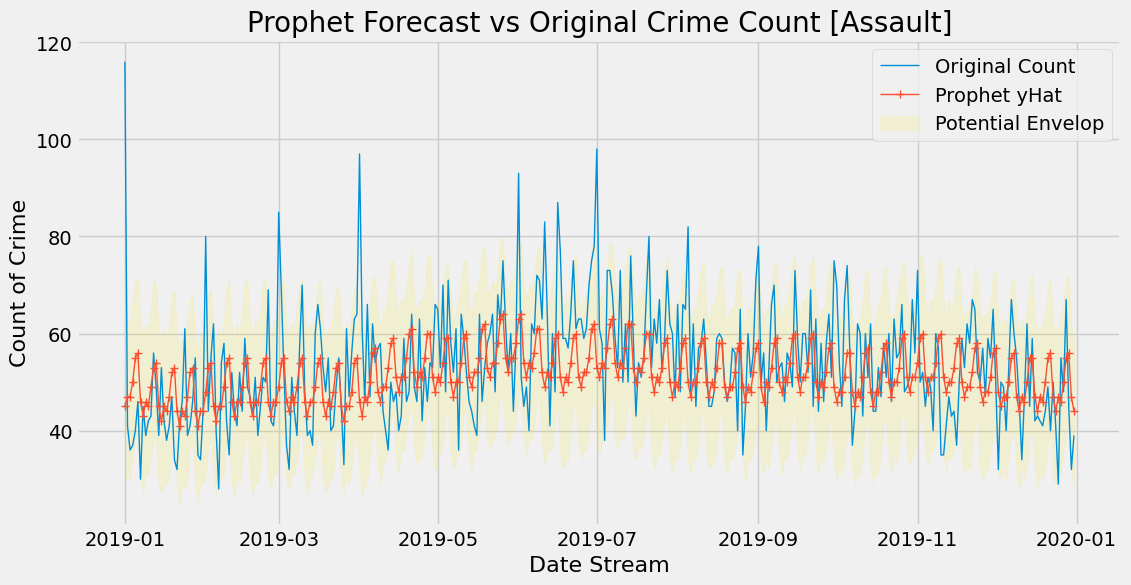

In [41]:
# Filter data from '2019-01-01' onwards
comparableData = assaultTimewiseData[assaultTimewiseData.ds >= pd.to_datetime('2019-01-01')]

# Add forecasted values to the dataframe
comparableData['yhat'] = assaultProphetForecast['yhat'].astype('int')
comparableData['yhatLower'] = assaultProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper'] = assaultProphetForecast['yhat_upper'].astype('int')

# Store results in mciDifferedResult
mciDifferedResult['Assault'] = comparableData['yhat']
mciDifferedResult['lower'] = comparableData['yhatLower']
mciDifferedResult['upper'] = comparableData['yhatUpper']

# Plot
plt.rcParams['figure.figsize'] = (12, 6)
plt.grid('on')
plt.title('Prophet Forecast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()


19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing


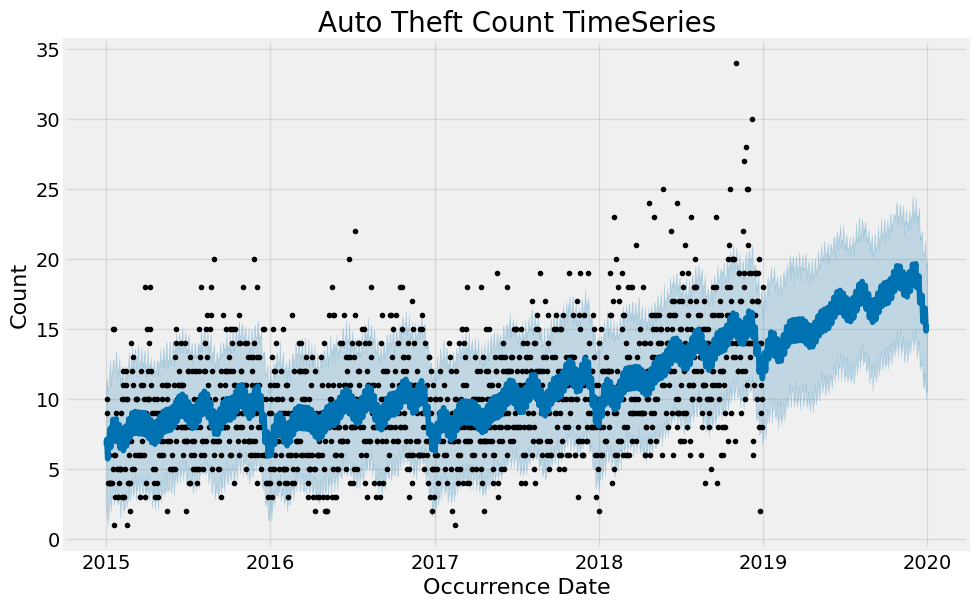

In [43]:
# Filter and prepare Auto Theft data for Prophet
autoTheftTimewiseData = df[df.MCI == 'Auto Theft'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
autoTheftTimewiseData = autoTheftTimewiseData[autoTheftTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31')].reset_index(drop=True).rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})

# Fit Prophet model
autoTheftProphetModel = Prophet(daily_seasonality=True).fit(autoTheftTimewiseData[autoTheftTimewiseData.ds < pd.to_datetime('2019-01-01')])

# Make future predictions
autoTheftProphetForecast = autoTheftProphetModel.make_future_dataframe(periods=365)
autoTheftProphetForecast = autoTheftProphetModel.predict(autoTheftProphetForecast)

# Plot the results
autoTheftProphetModel.plot(autoTheftProphetForecast, xlabel='Occurrence Date', ylabel='Count')
plt.title('Auto Theft Count TimeSeries')
plt.show()

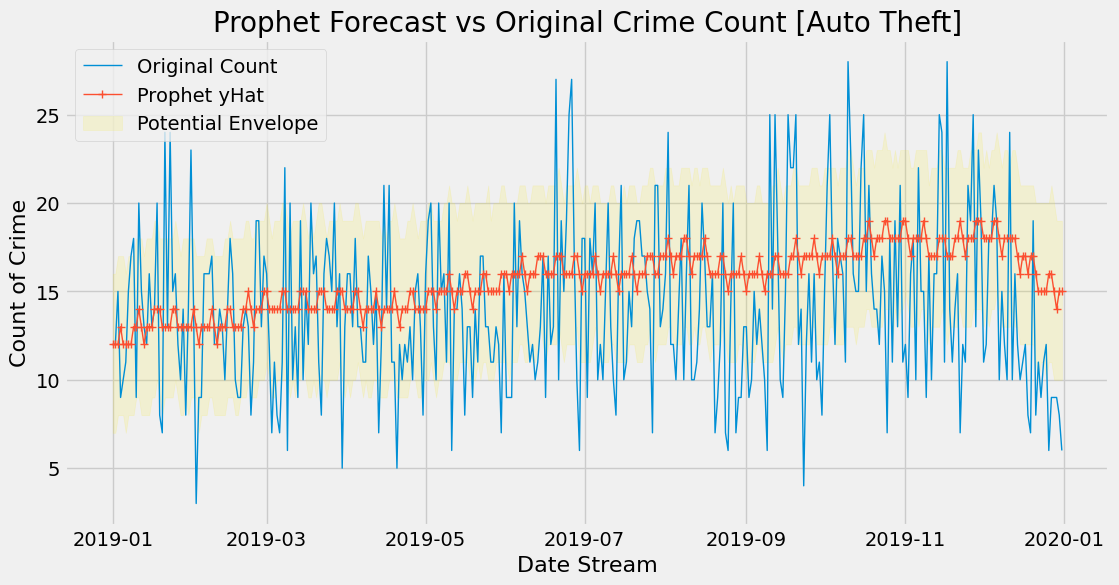

In [44]:
# Ensure both sides of the comparison are datetime64[ns] by removing .date()
comparableData = autoTheftTimewiseData[autoTheftTimewiseData.ds >= pd.to_datetime('2019-01-01')].copy()

# Add forecast columns to comparableData
comparableData['yhat'] = autoTheftProphetForecast['yhat'].astype('int')
comparableData['yhatLower'] = autoTheftProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper'] = autoTheftProphetForecast['yhat_upper'].astype('int')

# Initialize mciDifferedResult if not already done
if 'mciDifferedResult' not in globals():
    mciDifferedResult = pd.DataFrame(columns=['AutoTheft', 'lower', 'upper'])

# Add forecast data to mciDifferedResult
mciDifferedResult['AutoTheft'] = comparableData['yhat']
mciDifferedResult['lower'] = comparableData['yhatLower']
mciDifferedResult['upper'] = comparableData['yhatUpper']

# Plot the data
plt.grid(True)
plt.title('Prophet Forecast vs Original Crime Count [Auto Theft]')
plt.plot(comparableData.ds, comparableData['y'], lw=1, label='Original Count')
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+', label='Prophet yHat')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=0.15, label='Potential Envelope')
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend()
plt.show()